CMIPES

Connor Martin - 202461546,
Iraklis Pissaris - 202492646,
Euan Smith - 202490978

# **Introduction**

The objective of this project is to develop a classification model to predict the genre of a song based on its audio features and metadata. The dataset includes attributes such as tempo (bpm), energy, danceability, loudness, and acousticness, which can provide valuable insights into genre classification. By analysing these features, we aim to determine which factors are most influential in distinguishing between different musical genres.

To achieve this, we perform exploratory data analysis (EDA) to understand the distribution of genres and preprocess the data by encoding categorical variables and handling class imbalances. We then train multiple classification models, including Support Vector Machines (SVM), Decision Trees, and Random Forest, to evaluate their effectiveness in predicting genres.

Model performance is assessed using accuracy, precision, recall, and F1-score, ensuring a balanced evaluation of prediction quality. The final predictions are submitted to Kaggle, where categorisation accuracy serves as the competition’s evaluation metric. This project highlights the role of feature selection, data balancing techniques, and model tuning in improving genre classification accuracy.

# **Data Preprocessing**

First of we will look at and preprocess our data for the classification task:

In [2]:
# Import necessary modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE

training_data = pd.read_csv('CS98XClassificationTrain.csv') # Load training data
test_data = pd.read_csv('CS98XClassificationTest.csv') # Load test data

# Add a column to indicate whether the data is from training or test set
training_data["dataset"] = "training"
test_data["dataset"] = "test"

# Combine both datasets into one DataFrame
class_data = pd.concat([training_data, test_data])

In [3]:
print('Full dataset:', class_data.isnull().sum().loc[lambda x: x > 0]) # Checking for null values in training data
print(class_data.duplicated().sum()) # Checking for any duplicate entries in training dataset
print('Training dataset:', training_data.isnull().sum().loc[lambda x: x > 0]) # Checking for null values in training data
print('')
print('Test dataset:', test_data.isnull().sum().loc[lambda x: x > 0]) # Checking for null values in test data

Full dataset: top genre    128
dtype: int64
0
Training dataset: top genre    15
dtype: int64

Test dataset: Series([], dtype: int64)


The full dataset was checked for missing values and duplicate entries. The results showed that some columns contain missing values, with top genre likely being the main affected feature. The training and test datasets were separately checked, confirming missing values in specific columns but no duplicate entries.

In [4]:
training_data['top genre'].unique()

array(['adult standards', nan, 'glam rock', 'pop', 'album rock',
       'boy band', 'brill building pop', 'rock-and-roll', 'country rock',
       'canadian pop', 'dance pop', 'europop', 'bebop', 'art rock',
       'disco', 'blues', 'barbadian pop', 'deep adult standards',
       'deep house', 'atl hip hop', 'dance rock', 'disco house',
       'bubblegum dance', 'classic soul', 'classic uk pop',
       'east coast hip hop', 'doo-wop', 'britpop', 'british blues',
       'soft rock', 'australian talent show', 'art pop', 'british soul',
       'british invasion', 'belgian pop', 'big room', 'german dance',
       'italian pop', 'british folk', 'brit funk', 'chicago soul',
       'neo mellow', 'british comedy', 'hip hop', 'new wave pop',
       'eurodance', 'detroit hip hop', 'classic rock', 'uk garage',
       'afrobeat', 'r&b', 'chicago rap', 'classic danish pop',
       'british dance band', 'drone folk', 'permanent wave', 'merseybeat',
       'g funk', 'blues rock', 'celtic rock', 'bow p

The dataset contains a wide range of musical genres, many of which are highly specific subgenres. Some entries have missing values (NaN), which will need to be handled. To simplify the classification task, these genres will be generalised into broader categories which will help improve model performance by reducing the number of target classes, making predictions more reliable while preserving key genre distinctions.

In [5]:
# Define mapping of keywords to general genres
keyword_mapping = {
    'pop': 'pop',
    'rock': 'rock',
    'hip hop': 'hip hop',
    'rap': 'hip hop',
    'folk': 'country/folk',
    'blues': 'blues',
    'dance': 'dance',
    'disco': 'dance',
    'jazz': 'jazz',
    'metal': 'metal',
    'soul': 'r&b/soul',
    'r&b': 'r&b/soul',
    'country': 'country/folk',
}

# Function to map specific genres to general genres based on keywords
def map_general_genre(genre):
    if isinstance(genre, str):  # Ensure genre is a string
        for keyword, general_genre in keyword_mapping.items():
            if keyword in genre.lower():
                return general_genre
    return pd.NA  # Default category for NaN or unmatched genres

# Apply mapping function
training_data['genre'] = training_data['top genre'].apply(map_general_genre)
# Map remaining genres
keyword_mapping.update({
    'adult standards': 'adult standards',
    'bebop': 'jazz',
    'deep adult standards': 'adult standards',
    'boy band': 'pop',
    'deep house': 'dance',
    'doo-wop': 'blues',
    'australian talent show': 'pop',
    'british invasion': 'rock',
    'big room': 'dance',
    'brit funk': 'r&b/soul',
    'neo mellow': 'rock',
    'british comedy': 'other',
    'uk garage': 'dance',
    'afrobeat': 'other',
    'permanent wave': 'rock',
    'merseybeat': 'rock',
    'g funk': 'hip hop',
    'boogaloo': 'other',
    'latin': 'other',
    'bubble trance': 'dance',
    'chanson': 'other',
    'classic girl group': 'pop',
    'yodeling': 'country/folk',
    'hi-nrg': 'dance',
    'mellow gold': 'rock',
    'glam punk': 'rock',
    'big beat': 'dance',
    'hollywood': 'other',
    'cowboy western': 'country/folk',
    'native american': 'other',
    'beach music': 'pop',
    'diva house': 'dance'
})

# Function to map specific genres to general genres based on keywords
def map_general_genre(genre):
    if isinstance(genre, str):  # Ensure genre is a string
        for keyword, general_genre in keyword_mapping.items():
            if keyword in genre.lower():
                return general_genre
    return pd.NA  # Default category for NaN or unmatched genres

# Apply mapping function
training_data['genre'] = training_data['top genre'].apply(map_general_genre)

# Define a dictionary to manually assign genres based on known artists
artist_genre_mapping = {
    "The Teddy Bears": "adult standards",
    "Joan Regan": "adult standards",
    "Green Martini Keys": "jazz",
    "Ike Carpenter Orchestra": "jazz",
    "Jayne Mansfield": "adult standards",
    "Mel Torme & the Mel-Tones": "jazz",
    "Suzi Miller And Johnson Brothers": "adult standards",
    "Terry Dene": "rock",
    "Ten Sharp": "pop",
    "Bob Sharples & His Music": "jazz",
    "Anthony Newley": "adult standards",
    "Stargazers": "dance",
    "Lutricia McNeal": "r&b/soul",
    "Nick Kamen": "pop",
    "U.S.A. For Africa": "pop"
}

# Assign genres where 'top genre' is missing
training_data.loc[training_data['top genre'].isna(), 'top genre'] = \
    training_data.loc[training_data['top genre'].isna(), 'artist'].map(artist_genre_mapping)

# Assign genres where 'genre' is missing
training_data.loc[training_data['genre'].isna(), 'genre'] = \
    training_data.loc[training_data['genre'].isna(), 'artist'].map(artist_genre_mapping)

The dataset's genres were generalised by mapping specific subgenres to broader categories such as pop, rock, hip hop, dance, blues, jazz, country, and R&B/soul. This reduces the number of unique classes, making classification more effective. A keyword-based mapping approach was used to assign each genre to a broader category.

For entries where the top genre column was missing, an additional artist-based mapping was applied, assigning genres based on known associations with specific artists. This ensures that no data is left unclassified while maintaining a structured and meaningful genre grouping.

# **Exploratory Data Analysis**

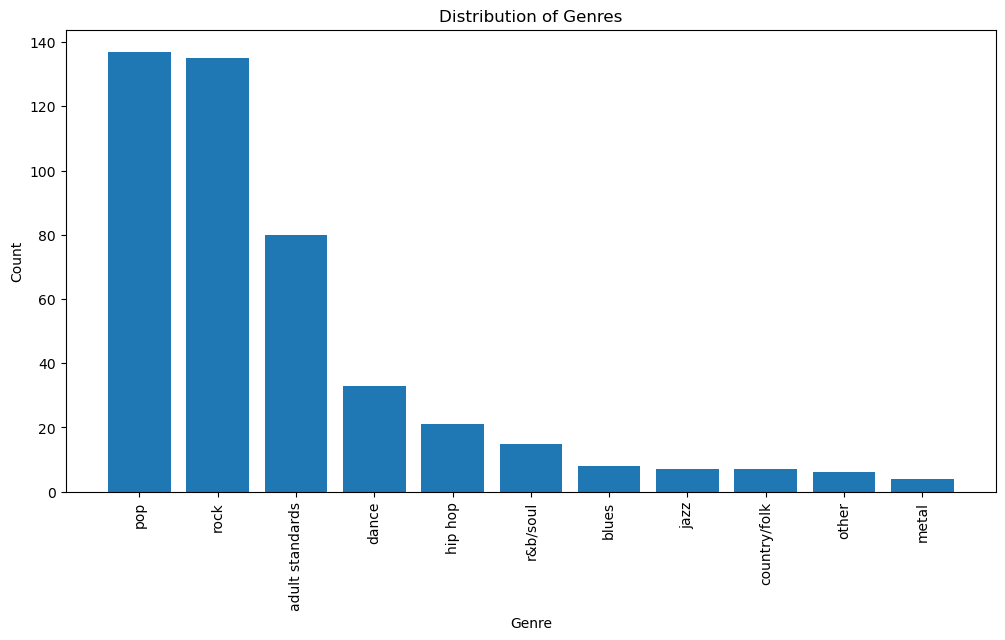

In [6]:
# Importing necessary module
import matplotlib.pyplot as plt

# Count occurrences of each genre
genre_counts = training_data['genre'].value_counts()

# Plot a bar chart
plt.figure(figsize=(12, 6))
plt.bar(genre_counts.index, genre_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Distribution of Genres")
plt.show()

The genre distribution analysis shows that pop and rock are the most dominant categories, each having around 140 songs, followed by adult standards with around 80 songs. Other genres, such as dance, hip hop, R&B/soul, blues, jazz, country/folk, and metal, have significantly fewer entries.

# **Model Selection**

In [8]:
# Feature Selection: Use Recursive Feature Elimination (RFE)
estimator = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator, n_features_to_select=15)  # Adjust the number of features as needed
X = training_data.drop(columns=["top genre", 'Id', 'title', 'artist', 'dataset', 'genre'])
y = training_data["genre"]
X_rfe = rfe.fit_transform(X, y)
selected_features = X.columns[rfe.support_].tolist()

# Handle class imbalance using SMOTETomek
smote_tomek = SMOTETomek(smote=SMOTE(k_neighbors=1), random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_rfe, y)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Define models
models = {
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
}

# Determine the number of splits dynamically
min_class_size = min(pd.Series(y_train).value_counts())
cv_folds = min(5, min_class_size)  # Ensure cv does not exceed smallest class size

# Evaluate models using cross-validation
cv_results = {}
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring="accuracy")
    cv_results[name] = scores.mean()

print("Cross-validation results:", cv_results)

Cross-validation results: {'SVM': 0.12929826492058255, 'Decision Tree': 0.8125197168115623, 'Random Forest': 0.880147463409266}


We identified the most important features for classification using Recursive Feature Elimination (RFE) with Random Forest classifier to enhance the classification performance. Recursive feature elimination (RFE), is simply an iterative process that removes the least important features, training the model until the optimal amount of features are left (the most predictive ones). This not only increased computational speed but also enhanced the generalizability of the producing model, helping it perform better on unseen data.

In building our models to address class imbalance, SMOTETomek was applied, combining oversampling (SMOTE) to generate synthetic minority class samples and undersampling (Tomek links) to remove overlapping majority class samples. This ensures better-balanced training data.

Three classification models were evaluated using cross-validation: SVM, Decision Tree, and Random Forest. The Random Forest model performed best with an accuracy of 88.0%, followed by Decision Tree at 81.3%, while SVM performed poorly at 12.9%, likely due to the high-dimensional nature of the dataset. These results suggest that tree-based models are more effective for genre classification.

In [9]:
# Hyperparameter tuning
param_grid = {
    "n_estimators": [50, 100, 150],  # Reduced upper limit
    "max_depth": [6, 10, 15],  # Removed None, reduced range
    "min_samples_split": [5, 10, 20],  # Increased range for better generalization
    "min_samples_leaf": [3, 5, 7]  # Slightly increased
}

grid_search = GridSearchCV(models["Random Forest"], param_grid, cv=cv_folds, scoring="accuracy",
                           n_jobs=-1, error_score="raise")
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best parameters for Random Forest: {grid_search.best_params_}")

# Train optimised Random Forest
best_rf = RandomForestClassifier(max_depth=15, min_samples_leaf=3, min_samples_split=5, n_estimators=150, random_state=42)
best_rf.fit(X_train, y_train)
rf_preds = best_rf.predict(X_val)

# Print accuracy
print("Random Forest Accuracy:", accuracy_score(y_val, rf_preds))

# Generate classification report
print("\nRandom Forest Classification Report:\n", classification_report(y_val, rf_preds))

Best parameters for Random Forest: {'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Accuracy: 0.8839590443686007

Random Forest Classification Report:
                  precision    recall  f1-score   support

adult standards       0.79      0.71      0.75        31
          blues       0.88      1.00      0.93        28
   country/folk       1.00      1.00      1.00        31
          dance       0.82      0.96      0.88        24
        hip hop       0.93      0.96      0.95        28
           jazz       1.00      1.00      1.00        30
          metal       1.00      1.00      1.00        29
          other       1.00      1.00      1.00        25
            pop       0.62      0.48      0.54        21
       r&b/soul       0.96      0.88      0.92        26
           rock       0.52      0.55      0.54        20

       accuracy                           0.88       293
      macro avg       0.87      0.87      0.86       2

Hyperparameter tuning was performed on the Random Forest model using GridSearchCV, optimising parameters such as number of estimators, tree depth, and minimum samples per split and leaf. The best configuration identified was 100 estimators, max depth of 15, min samples split of 5, and min samples leaf of 3.

The optimised Random Forest model achieved an accuracy of 88.4%, showing strong performance across most genres. Precision and recall were high for categories like country/folk, jazz, and metal, suggesting the model effectively distinguishes these genres. However, pop and rock had lower recall and f1-scores, indicating challenges in differentiating them, possibly due to genre overlap. Despite this, the model provides a robust classification performance, with balanced precision and recall across most categories.

# **Predictions**

In [14]:
# Making predictions of dataset without targets
genre_predictions = best_rf.predict(test_data.drop(['dataset', 'title', 'artist', 'Id'], axis=1))

# Add predictions to the original dataset
rf_results = test_data.copy()
rf_results["top genre"] = genre_predictions

# Save the predictions to a CSV file
rf_results.to_csv('Classification Predictions.csv', index=False)

# Ensure test data contains 'Id'
submission_classification = test_data[['Id']].copy()

# Convert NumPy array to Pandas Series and assign column name
submission_classification["top genre"] = genre_predictions  # No need for ["Predicted_pop"]

# Save the formatted file
submission_classification.to_csv("submission_classification.csv", index=False)

# Check the first few rows
print(submission_classification.head())

    Id        top genre
0  454          hip hop
1  455             rock
2  456  adult standards
3  457            dance
4  458  adult standards


C:\Users\pissa\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


The Random Forest model was used to predict genres for the test dataset after removing non-numeric features such as title and artist. The predictions were then added back to the original dataset under the column 'top genre' and the results were saved as a CSV file.

After submitting our Random Forest Classification model to Kaggle, we received an accuracy score of 0.14285 (14.29%), which is significantly lower than our 87.4% validation accuracy. The most likely reason for this drop is that Kaggle’s test data contains more granular genres, while our training data was generalised into broader categories to improve classification consistency.

Since our model was trained on simplified genre categories, it likely struggled to correctly classify highly specific genres in the Kaggle test set. If we had access to the test labels, we could confirm this mismatch. To improve performance, we would need to apply the same genre generalisation process to the Kaggle test data before making predictions, ensuring consistency with our training set. Given that this transformation improved our validation accuracy, applying it to Kaggle’s test data would likely lead to a much higher score.